In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

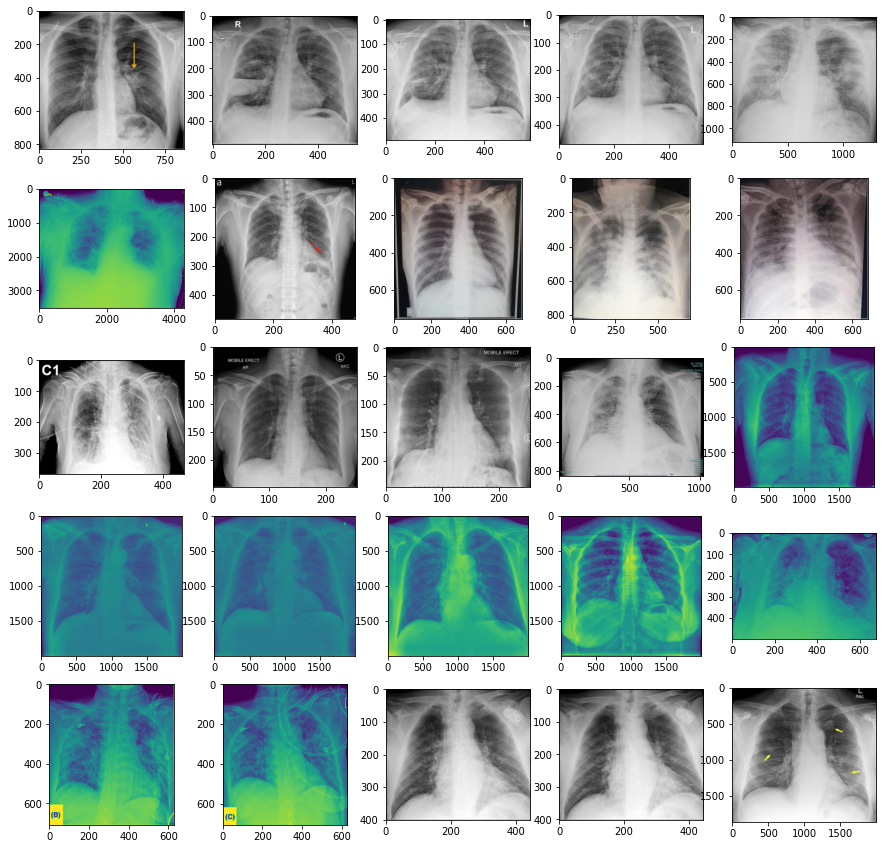

In [74]:
#Mostramos unas cuántas imagenes
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
carpeta='B:\\Documentos\\Estudio\\Maestría\\Aprendizaje_Computacional\\Implementacion\\Deteccion_Articulo\\dataset\\Xray-sanos'
imagenes=os.listdir(carpeta)

for i, name in enumerate(imagenes[:25]):
    plt.subplot(5,5,i+1)
    imagen=mpimg.imread(carpeta+'/'+name)
    plt.imshow(imagen)

In [75]:
from keras.applications.densenet import DenseNet121
conv_base=DenseNet121(input_shape=(224,224,3))

In [76]:
train_dir='B:\\Documentos\\Estudio\\Maestría\\Aprendizaje_Computacional\\Implementacion\\Deteccion_Articulo\\dataset'
#Corregir este punto, puse los mismos de validación sólo para ver si se ejecutava el código

valid_dir='B:\\Documentos\\Estudio\\Maestría\\Aprendizaje_Computacional\\Implementacion\\Deteccion_Articulo\\dataset'
img_width, img_height = 224, 224

In [77]:
# Paso de extracción de características con modelo DenseNet121
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1000))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,4))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 269)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 269)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 269 images belonging to 4 classes.
1/1 [==============================] - 2s 2s/step
Found 269 images belonging to 4 classes.
1/1 [==============================] - 1s 638ms/step


In [78]:
#Dimensiones del vector de características
print(train_labels.shape)
print(train_features.shape)

(269, 4)
(269, 1000)


In [79]:
#Aquí ya no importa que haya puesto los datos de validacioón y entrenamiento iguales, aquí sólo tomo un conjunto y divido para la validación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, stratify=train_labels, random_state=10)

In [80]:
print(X_train.shape)
print(X_test.shape)

(201, 1000)
(68, 1000)


In [81]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [82]:
scores = cross_val_score(DecisionTreeClassifier(), train_features, train_labels, cv=5)
print(scores)

[0.7962963  0.74074074 0.83333333 0.7037037  0.88679245]


In [83]:
scores.mean()

0.7921733053808525

In [84]:
#Creamos ya el modelo con Bagging
bag_model = BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
)

In [85]:
#El modelo de Bagging sólo acepta entradas de etiquetas de una dimensión, así que aquí creo el vector etiquetas pero para que tenga solo  una dimensión (1000)
y=np.zeros(201)
for i in range(y_train.shape[0]):
    if y_train[i][0]==1:
        y[i]=1
    elif y_train[i][1]==1:
        y[i]=2
    elif y_train[i][2]==1:
        y[i]=3
    elif y_train[i][3]==1:
        y[i]=4
print(i)

200


In [86]:
#Clasificamos
bag_model.fit(X_train, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5)

In [98]:
y_test[0]

array([0., 0., 0., 1.])

In [101]:
y_testeo=np.zeros(68)
for i in range(68):
    if y_test[i][0]==1:
        y_testeo[i]=1
    elif y_test[i][1]==1:
        y_testeo[i]=2
    elif y_test[i][2]==1:
        y_testeo[i]=3
    elif y_test[i][3]==1:
        y_testeo[i]=4
print(i)

67


In [102]:
y_testeo

array([4., 4., 3., 3., 1., 3., 4., 1., 3., 4., 3., 4., 3., 4., 3., 1., 3.,
       3., 3., 3., 4., 3., 4., 2., 4., 3., 3., 4., 3., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 3., 3., 2., 4., 4., 3., 4., 1., 4., 3., 4.,
       3., 3., 3., 3., 3., 2., 4., 3., 3., 3., 4., 3., 2., 4., 4., 3., 2.])

In [103]:
bag_model.score(X_test, y_testeo)

0.8529411764705882